In [5]:
import torch
import torchvision
from components import NeuralProcess
from torch import nn
from train_val import train_and_validate
from utils import DataModule, img_to_x_y, x_y_to_img

In [6]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [7]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.MNIST(root='/home/chickencurry/diffusion-vi-neural-processes/data', train=True, transform=transform, download=True)

data_module = DataModule(
    batch_size=64,
    dataset_and_split=(dataset, (0.8, 0.2)),
)

In [8]:
model = NeuralProcess(
    x_dim=2, 
    y_dim=1, 
    r_dim=32, 
    z_dim=32, 
    h_dim=512, 
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
recon_criterion = nn.BCEWithLogitsLoss(reduction='mean')

In [9]:
avg_train_recon_losses, avg_train_kl_divs, avg_val_recon_losses, avg_val_kl_divs = train_and_validate(
    model=model,
    data_module=data_module,
    num_epochs=5,
    device=device,
    optimizer=optimizer,
    recon_criterion=recon_criterion,
    kl_reduction='mean',
    preprocessing=img_to_x_y
)

  0%|          | 0/750 [00:00<?, ?it/s]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/nn/functional.py:3226: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)
 22%|██▏       | 165/750 [00:27<01:36,  6.07it/s, epoch=1, kl_div=0.0147, recon_loss=0.305]   

: 

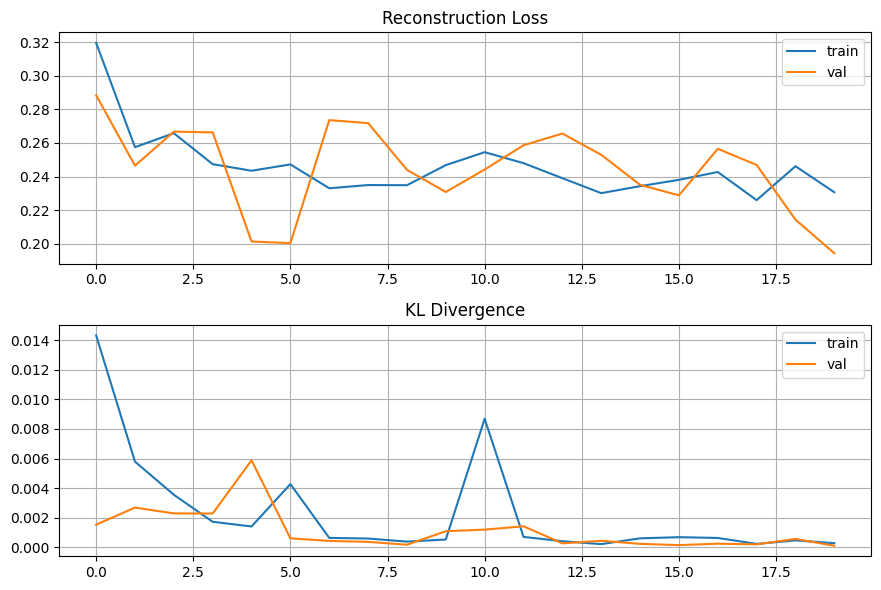

In [6]:
from matplotlib import pyplot as plt

_, ax = plt.subplots(2, 1, figsize=(9, 6))

ax[0].plot(avg_train_recon_losses, label="train")
ax[0].plot(avg_val_recon_losses, label="val")
ax[0].set_title("Reconstruction Loss")
ax[0].grid()
ax[0].legend()

ax[1].plot(avg_train_kl_divs, label="train")
ax[1].plot(avg_val_kl_divs, label="val")
ax[1].set_title("KL Divergence")
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

In [90]:
from utils import split_context_target

gen_dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=10)
sample = next(iter(gen_dataloader))

factor = 0.2 # max(min(0.9, np.random.random()), 0.1)
x_data, y_data = img_to_x_y(sample[0])
x_context, y_context, x_target, y_target = split_context_target(x_data, y_data, factor, random=True)
print(x_context.shape, y_context.shape, x_target.shape, y_target.shape)

torch.Size([1, 156, 2]) torch.Size([1, 156, 1]) torch.Size([1, 628, 2]) torch.Size([1, 628, 1])


torch.Size([1, 1, 28, 28])


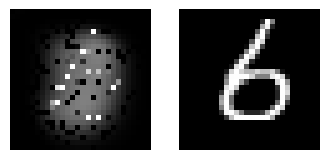

In [92]:
from matplotlib import pyplot as plt

n_samples = 1

model.eval()
with torch.no_grad():
    x_context = x_context.to(device)
    y_context = y_context.to(device)
    x_target = x_target.to(device)
    y_target = y_target.to(device)
    
    mus, logvars, _, _ = model.sample(x_context, y_context, x_target, n_samples)
    mus = torch.sigmoid(mus)

    x_new = torch.cat([x_context, x_target], dim=1).cpu()
    y_new = torch.cat([y_context, mus], dim=1).cpu()

    img_batch = x_y_to_img(x_new, y_new)
    print(img_batch.shape)

    fig, ax = plt.subplots(1, 2, figsize=(4, 8))

    ax[0].imshow(img_batch[0].detach().cpu().permute(1, 2, 0), cmap="gray")
    ax[0].axis("off")

    ax[1].imshow(sample[0][0].detach().cpu().permute(1, 2, 0), cmap="gray")
    ax[1].axis("off")
    plt.show()